## Spacial Regression

--> Embed location through the model

In [2192]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import wkt
from pysal.lib import weights
from pysal.explore import esda
import numpy
import pandas
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns
import contextily
from pysal.model import spreg
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from libpysal.weights import KNN
from spreg import OLS
from libpysal.weights import lag_spatial
from spreg import GM_Lag
from libpysal.weights import Kernel

## Load data

In [2193]:
current_dir = os.getcwd()
path = os.path.join(current_dir, '../data/clean', "merged_dataset_1.csv")
df = pd.read_csv(path)

In [2194]:
df = df[df["Year"] == 2012].copy()
len(df)

47

## Remove outlier based on "Soil type"

In [2195]:
df = df[df["HGRnaam"] != "veen"].copy()

In [2196]:
print(df["HGRnaam"].value_counts())

HGRnaam
zand    32
klei    11
Name: count, dtype: int64


In [2197]:
df["HGRnaam"] = pd.Categorical(df["HGRnaam"], categories=["zand", "klei"])

In [2198]:
print(df["HGRnaam"].value_counts())

HGRnaam
zand    32
klei    11
Name: count, dtype: int64


## Log Nitrate values

In [2199]:
df["log_nitrate"] = np.log1p(df["Nitrate"])

## Remove spatial outlier

In [2200]:
df = df.drop(df[df["Well_ID"] == "GMW000000024093"].index)

## Remove nitrate outliers

In [2201]:
# q1 = df["Nitrate"].quantile(0.25)
# q3 = df["Nitrate"].quantile(0.75)
# iqr = q3 - q1

# lower_bound = q1 - 1.5 * iqr
# upper_bound = q3 + 1.5 * iqr

# outliers = df[(df["Nitrate"] < lower_bound) | (df["Nitrate"] > upper_bound)]
# print(f"Outliers found: {len(outliers)}")
# outliers

# top_nitrate_outliers = list(df["Nitrate"].sort_values()[-len(outliers):].index)
# top_nitrate_outliers
# df = df.drop(top_nitrate_outliers)
# len(df)

## Convert to Geo table

In [2202]:
df['geometry'] = df['geometry'].apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:28992')

## Remove overlapping nodes (same location)

In [2203]:
gdf_unique = df.drop_duplicates(subset="geometry", keep="first").reset_index(drop=True)

df = gdf_unique.to_crs(epsg=3857)
len(df)

39

## Select features

In [2204]:
cols_to_drop = [
    'Well_ID', 'BRO-ID', 'Filter', 'Date', 'distance_m', 'Year', 'lon', 'lat',
    'Unnamed: 0', 'Total Livestock', 'Excretion during grazing (million kg)', 'Municipal waste (1000 tonnes)/Total municipal waste (1 000 tonnes)',
    'Nitrogen losses in housing and storages/Total nitrogen losses (N) (million kg)',
    'Use of livestock manure in agriculture (million kg)', 'Mineral fertiliser N/ha in kg'
]

df = df.drop(columns=cols_to_drop, errors="ignore")

In [2205]:
df['Landuse_Code'] = df['Landuse_Code'].fillna(-1).astype(int)

df['HGRnaam'] = df['HGRnaam'].astype("category")
df['Landuse_Code'] = df['Landuse_Code'].astype("category")

In [2206]:
df = df.dropna()
len(df)

39

## Split into features and target

In [2207]:
X_cat = pd.get_dummies(df[['Landuse_Code']], drop_first=True)
X_num = df.drop(columns=['Nitrate', 'HGRnaam', 'Landuse_Code', "log_nitrate"])
X_num = X_num.select_dtypes(include=[np.number]) 

X_all = pd.concat([X_num, X_cat], axis=1)
X_all = X_all.astype(float)

In [2208]:
X_check = X_all.copy()
X_check["HGRnaam"] = df["HGRnaam"]
grouped_uniques = X_check.groupby("HGRnaam").nunique()
drop_cols = grouped_uniques.columns[grouped_uniques.min() <= 1]
X_all = X_all.drop(columns=drop_cols).copy()

/var/folders/fr/h0n611t55y51b_mts5q50l540000gn/T/ipykernel_25261/131791510.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_uniques = X_check.groupby("HGRnaam").nunique()


In [2209]:
y = df['log_nitrate'].values.reshape(-1, 1)
# X = np.hstack([np.ones((X_all.shape[0], 1)), X_all.values])
X = X_all.values

In [2210]:
ols_model = spreg.OLS(y, X, name_y='log_nitrate', name_x=list(X_all.columns))
print(ols_model.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  : log_nitrate                Number of Observations:          39
Mean dependent var  :      1.3951                Number of Variables   :           9
S.D. dependent var  :      1.1091                Degrees of Freedom    :          30
R-squared           :      0.3635
Adjusted R-squared  :      0.1937
Sum squared residual:     29.7542                F-statistic           :      2.1413
Sigma-square        :       0.992                Prob(F-statistic)     :     0.06271
S.E. of regression  :       0.996                Log likelihood        :     -50.062
Sigma-square ML     :       0.763                Akaike info criterion :     118.124
S.E of regression ML:      0.8735                Schwarz criterion     :     133.096

------------------------------------------------------------

## Outlier clusters

In [2211]:
knn = weights.KNN.from_dataframe(df, k=4)

/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/spatial_env/lib/python3.9/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
  warnings.warn(message)


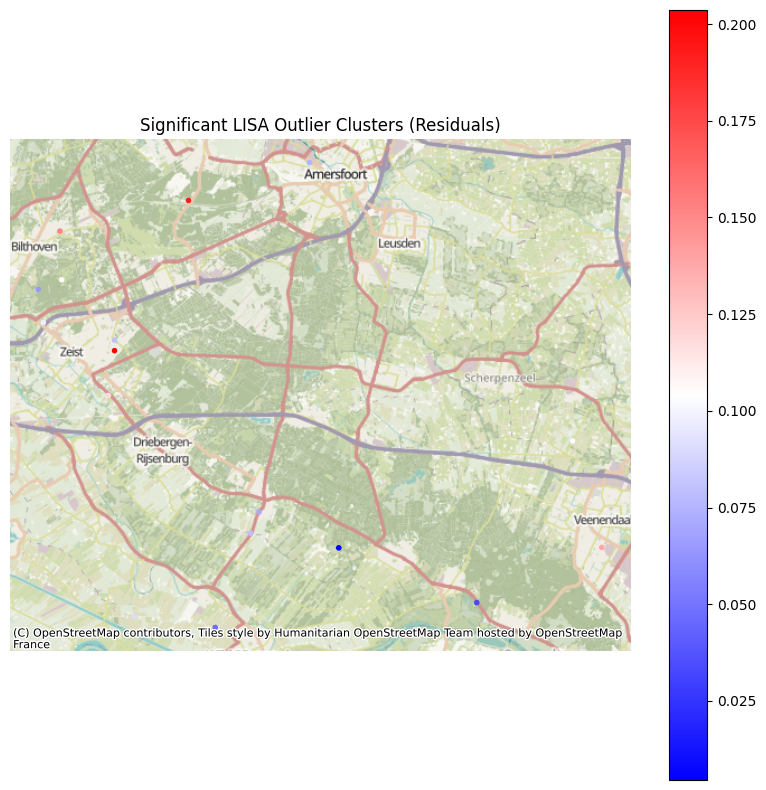

<Figure size 640x480 with 0 Axes>

In [2212]:
# Re-weight W to 20 nearest neighbors
knn.reweight(k=15, inplace=True)
# Row standardize weights
knn.transform = "R"
# Run LISA on residuals
outliers = esda.moran.Moran_Local(ols_model.u, knn, permutations=9999)
# Select only LISA cluster cores
error_clusters = outliers.q % 2 == 1
# Filter out non-significant clusters

# error_clusters &= outliers.p_sim <= 0.05

# Add `error_clusters` and `local_I` columns

#---------------------------

error_df = df.assign(
    error_clusters=error_clusters,
    local_I=outliers.Is
).query("error_clusters").sort_values("local_I")

fig, ax = plt.subplots(figsize=(10, 10))
error_df.plot("local_I", cmap="bwr", marker=".", ax=ax, legend=True)
contextily.add_basemap(ax, crs=df.crs)
ax.set_axis_off()
plt.title("Significant LISA Outlier Clusters (Residuals)")
plt.show()

#---------------------------

contextily.add_basemap(ax, crs=df.crs)
ax.set_axis_off()

## Spatial fixed effects

--> We influence constant term

--> Instead of assuming the dependent variable behaves uniformly over space, there are systematic effects following a geographical pattern

--> Constant term to vary geographically

--> **Other** elements of the regression are left untouched and hence apply **uniformly** across space

--> Each region gets its own intercept

--> Control for spatial heterogeneity

In [2213]:
predictors = ["avg_depth_m", "Population", "C(Landuse_Code)", "avg_temp_mean", "avg_precip_sum", "Elevation_m"]
formula = "log_nitrate ~ " + " + ".join(predictors) + " + C(HGRnaam) - 1"

In [2214]:
model = smf.ols(formula, data=df).fit()

In [2215]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            log_nitrate   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     2.452
Date:                Sun, 25 May 2025   Prob (F-statistic):             0.0260
Time:                        18:31:41   Log-Likelihood:                -38.908
No. Observations:                  39   AIC:                             111.8
Df Residuals:                      22   BIC:                             140.1
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
C(Landuse_Code)[1]      0.8317    

#### Wells on **zand** soils have significantly **higher nitrate** concentrations, even when controlling for depth, population, temperature

In [2216]:
print(model.params.index)

Index(['C(Landuse_Code)[1]', 'C(Landuse_Code)[2]', 'C(Landuse_Code)[11]',
       'C(Landuse_Code)[12]', 'C(Landuse_Code)[18]', 'C(Landuse_Code)[20]',
       'C(Landuse_Code)[23]', 'C(Landuse_Code)[25]', 'C(Landuse_Code)[26]',
       'C(Landuse_Code)[28]', 'C(Landuse_Code)[62]', 'C(HGRnaam)[T.klei]',
       'avg_depth_m', 'Population', 'avg_temp_mean', 'avg_precip_sum',
       'Elevation_m'],
      dtype='object')


--> The log nitrate concentration is, on average, 1.30 units lower in klei (clay) regions

In [2217]:
sfe_names = [i for i in model.params.index if "C(HGRnaam)" in i]

soil_fixed_effects = pd.DataFrame({
    "Coef.": model.params[sfe_names],
    "Std. Error": model.bse[sfe_names],
    "P-Value": model.pvalues[sfe_names],
})

soil_fixed_effects.index = [name.split("[T.")[1].strip("]") for name in sfe_names]
soil_fixed_effects.index.name = "soil_type"
soil_fixed_effects.reset_index(inplace=True)
soil_fixed_effects

,soil_type,Coef.,Std. Error,P-Value
0,klei,-1.302341,0.479248,0.012575


In [2218]:
sfe_names

['C(HGRnaam)[T.klei]']

In [ ]:
wells = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:3857")

soil_fixed_effects = model.params.filter(like="C(HGRnaam)")
soil_fixed_effects.index = soil_fixed_effects.index.str.extract(r"C\(HGRnaam\)\[T\.(.*)\]")[0]
soil_fixed_effects.name = "fixed_effect"
soil_fixed_effects = soil_fixed_effects.reset_index().rename(columns={0: "soil_type"})

wells = wells.merge(soil_fixed_effects, how="left", left_on="HGRnaam", right_on="soil_type")

ax = wells.plot(
    column="fixed_effect",
    cmap="coolwarm",
    legend=True,
    figsize=(10, 6),
    markersize=30,
    missing_kwds={"color": "grey", "label": "No fixed effect"}
)

contextily.add_basemap(ax, crs=wells.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title("Soil Type Fixed Effects at Well Locations")
plt.tight_layout()
plt.show()

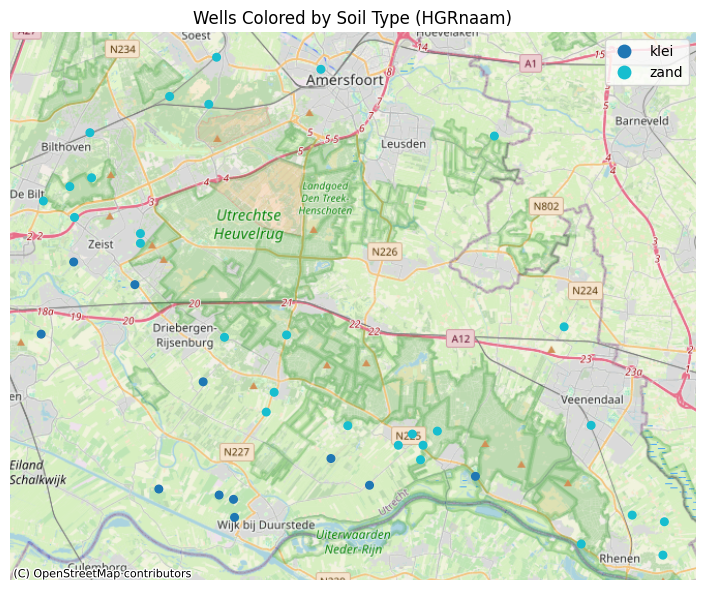

In [2220]:
ax = wells.plot(
    column="HGRnaam",
    categorical=True,
    legend=True,
    figsize=(10, 6),
    markersize=30,
    cmap="tab10"
)

contextily.add_basemap(ax, crs=wells.crs, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.title("wells colored by soil type")
plt.tight_layout()
plt.show()

## Spatial Regimes

--> We modify set of coeficients depending on the location

--> Spatial regimes (SRs) is to generalize the spatial FE approach to allow not only the constant term to vary but also any other explanatory variable

--> We want the whole model — intercept and slopes — to vary between geographic groups

In [2221]:
m5 = spreg.OLS_Regimes(
    y,
    X,
    df["HGRnaam"].tolist(),
    constant_regi="many",  # intercept per group
    regime_err_sep=False,
    name_y="log_nitrate",
    name_x=list(X_all.columns),
)

In [2222]:
print(m5.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  : log_nitrate                Number of Observations:          39
Mean dependent var  :      1.3951                Number of Variables   :          18
S.D. dependent var  :      1.1091                Degrees of Freedom    :          21
R-squared           :      0.6053
Adjusted R-squared  :      0.2857
Sum squared residual:     18.4517                F-statistic           :      1.8941
Sigma-square        :       0.879                Prob(F-statistic)     :     0.08282
S.E. of regression  :       0.937                Log likelihood        :     -40.745
Sigma-square ML     :       0.473                Akaike info criterion :     117.489
S.E of regression ML:      0.6878                Schwarz criterion     :     147.433

----------------------------------------

CHOW test check if coefficients for each predictor is statistically different across the groups (klei vs zand)

In [2223]:
res = pd.DataFrame({
    "Coeff.": m5.betas.flatten(),
    "Std. Error": m5.std_err.flatten(),
    "P-Value": [i[1] for i in m5.t_stat],
}, index=m5.name_x)

soil_types = df["HGRnaam"].unique()

regime_tables = []
for soil in soil_types:
    matching_rows = [i for i in res.index if i.startswith(f"{soil}_")]
    regime_res = res.loc[matching_rows].rename(lambda i: i.replace(f"{soil}_", ""))
    regime_res.columns = pd.MultiIndex.from_product([[soil], regime_res.columns])
    regime_tables.append(regime_res)

comparison_table = pd.concat(regime_tables, axis=1)

comparison_table

zand                           klei                     
                   Coeff. Std. Error   P-Value    Coeff. Std. Error   P-Value
CONSTANT         1.574620   0.548285  0.009127  1.826115   4.225760  0.670045
avg_depth_m      0.090649   0.096132  0.356420  0.092922   0.393461  0.815593
Population       0.000142   0.000415  0.736059  0.019825   0.029784  0.512892
avg_temp_mean   -0.006989   0.005833  0.244235  0.003128   0.087562  0.971844
avg_precip_sum  -0.023815   0.016546  0.164806  0.010630   0.025257  0.678141
Elevation_m      0.012252   0.016736  0.472189 -0.496791   1.036575  0.636705
Landuse_Code_11  0.647492   0.479906  0.191640  6.524202   9.911971  0.517552
Landuse_Code_18 -0.050494   0.826686  0.951873 -6.409038   8.878040  0.478319
Landuse_Code_26  1.136504   0.760001  0.149688 -0.249949   1.517684  0.870762

--> Intercept is statistically significant (p = 0.009), suggesting a reliable baseline nitrate level when other predictors are zero

--> !! the magnitude and direction of the coefficients still differ between the two group

## Spatial dependence

--> Maybe neighbors surrounding the data point influence its value

--> We add spatial context

--> Calculate average of variables in the surrounding locations

--> NOTE: simple knn **worked better** than kernel

In [2224]:
knn = KNN.from_dataframe(wells, k=4)

In [2225]:
X_all.columns

Index(['avg_depth_m', 'Population', 'avg_temp_mean', 'avg_precip_sum',
       'Elevation_m', 'Landuse_Code_11', 'Landuse_Code_18', 'Landuse_Code_26'],
      dtype='object')

In [2226]:
lagged_vars = ['avg_depth_m', 'Population', 'avg_temp_mean', 'avg_precip_sum',
       'Elevation_m']

wx = X_all[lagged_vars].apply(lambda col: lag_spatial(knn, col), axis=0)  #spatial lag to each variable

wx.columns = ["w_" + col for col in wx.columns]# renaming

In [2227]:
slx_X = pd.concat([X_all, wx], axis=1)  # combine original and lagged features

In [2228]:
y = df["log_nitrate"].values.reshape(-1, 1)

In [2229]:
m6 = OLS(
    y=y,
    x=slx_X.values,
    name_y="log_nitrate",
    name_x=slx_X.columns.tolist(),
)

In [2230]:
print(m6.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  : log_nitrate                Number of Observations:          39
Mean dependent var  :      1.3951                Number of Variables   :          14
S.D. dependent var  :      1.1091                Degrees of Freedom    :          25
R-squared           :      0.5258
Adjusted R-squared  :      0.2792
Sum squared residual:     22.1666                F-statistic           :      2.1322
Sigma-square        :       0.887                Prob(F-statistic)     :     0.05042
S.E. of regression  :       0.942                Log likelihood        :     -44.322
Sigma-square ML     :       0.568                Akaike info criterion :     116.643
S.E of regression ML:      0.7539                Schwarz criterion     :     139.933

------------------------------------------------------------

In [2231]:
lagged_names = wx.columns

slx_results = pd.DataFrame({
    "Coeff.": m6.betas.flatten(),
    "Std. Error": m6.std_err.flatten(),
    "P-Value": [t[1] for t in m6.t_stat],
}, index=m6.name_x)

# View just the spatial lag effects (and round for readability)
slx_results.loc[lagged_names].round(4)


,Coeff.,Std. Error,P-Value
w_avg_depth_m,-0.0454,0.0445,0.3176
w_Population,0.0008,0.0003,0.0378
w_avg_temp_mean,-0.0064,0.0039,0.1139
w_avg_precip_sum,0.0221,0.0124,0.0852
w_Elevation_m,0.0216,0.0090,0.0238


Neigboring Population, Elevation significantly effect the Nitrate level at specific location

## Spacial Lag

--> How Y variable in neighborhood affects Y variable in other location

--> NOTE: Lagging nitrate from neighbours can be problematic. Nitrate is not sampled at the same time across the area

In [2232]:
m8 = GM_Lag(
    y=y,
    x=X,
    w=knn,
    name_y="log_nitrate",
    name_x=list(X_all.columns),
)

In [2233]:
print(m8.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : log_nitrate                Number of Observations:          39
Mean dependent var  :      1.3951                Number of Variables   :          10
S.D. dependent var  :      1.1091                Degrees of Freedom    :          29
Pseudo R-squared    :      0.3543
Spatial Pseudo R-squared:  0.3307

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         0.22426         0.50759         0.44181         0.65862
         avg_depth_m         0.11668         0.07872         1.48225         0.13827
          Population         0.00039      

In [2234]:
pd.DataFrame({
    "Coeff.": m8.betas.flatten(),
    "Std. Error": m8.std_err.flatten(),
    "P-Value": [z[1] for z in m8.z_stat],
}, index=m8.name_z).round(4)

,Coeff.,Std. Error,P-Value
CONSTANT,0.2243,0.5076,0.6586
avg_depth_m,0.1167,0.0787,0.1383
Population,0.0004,0.0004,0.2867
avg_temp_mean,-0.0048,0.0050,0.3356
avg_precip_sum,-0.0092,0.0113,0.4180
Elevation_m,0.0146,0.0161,0.3643
Landuse_Code_11,0.4109,0.4313,0.3407
Landuse_Code_18,-0.6794,0.5995,0.2571
Landuse_Code_26,0.0923,0.5933,0.8764
W_log_nitrate,0.1232,0.0844,0.1440


## Sum up the results

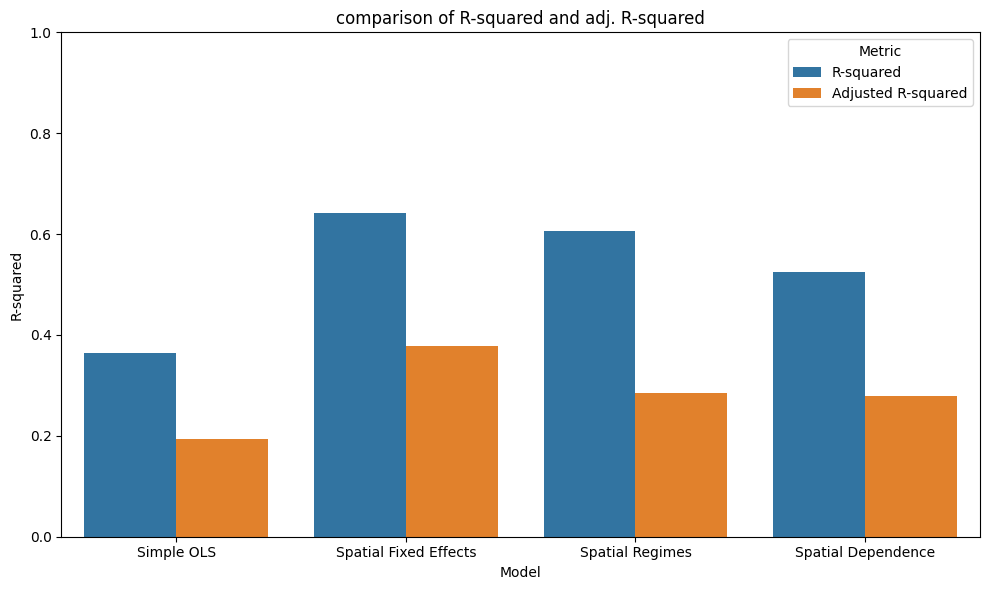

In [2237]:
data = {
    "Model": [
        "Simple OLS", "Simple OLS",
        "Spatial Fixed Effects", "Spatial Fixed Effects",
        "Spatial Regimes", "Spatial Regimes",
        "Spatial Dependence", "Spatial Dependence"
    ],
    "Metric": [
        "R-squared", "Adjusted R-squared",
        "R-squared", "Adjusted R-squared",
        "R-squared", "Adjusted R-squared",
        "R-squared", "Adjusted R-squared"
    ],
    "Value": [
        0.3635, 0.1937,
        0.641, 0.379,
        0.6053, 0.2857,
        0.5258, 0.2792
    ]
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="Model", y="Value", hue="Metric")
plt.title("comparison of R-squared and adj. R-squared")
plt.ylabel("R-squared")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
